In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x235102b2ec0>,
 'tobs': 65.0,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08}

# Exploratory Precipitation Analysis

In [17]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

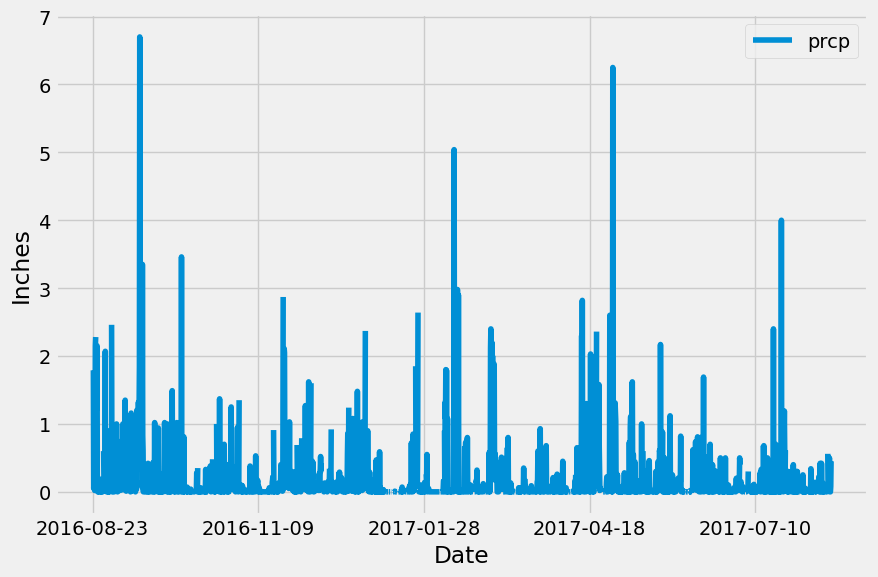

In [132]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
end_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
# Calculate the date one year from the last date in data set.
start_date = dt.datetime.strptime(end_date, '%Y-%m-%d') - dt.timedelta(days=366)
#print(start_date, end_date)
# Perform a query to retrieve the data and precipitation scores

precep_scores = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
precep_df = pd.DataFrame(precep_scores, columns=['date', 'prcp']) 

# Sort the dataframe by date
precep_df = precep_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
precep_df.set_index('date', inplace=True)
ax = precep_df.plot(figsize=(9,6))
plt.xlabel("Date")
plt.ylabel("Inches")
plt.tight_layout()
plt.show()

In [133]:
# Use Pandas to calculate the summary statistics for the precipitation data

precep_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [74]:
# Design a query to calculate the total number of stations in the dataset
session.query(Station.station).count()

9

In [78]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel = [Measurement.station,
       func.count(Measurement.id)]
station_counts = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [80]:
top_station = station_counts[0][0]
top_station

'USC00519281'

In [84]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
top_data = session.query(*sel).\
    filter(Measurement.station == top_station).all()
top_data

[(54.0, 85.0, 71.66378066378067)]

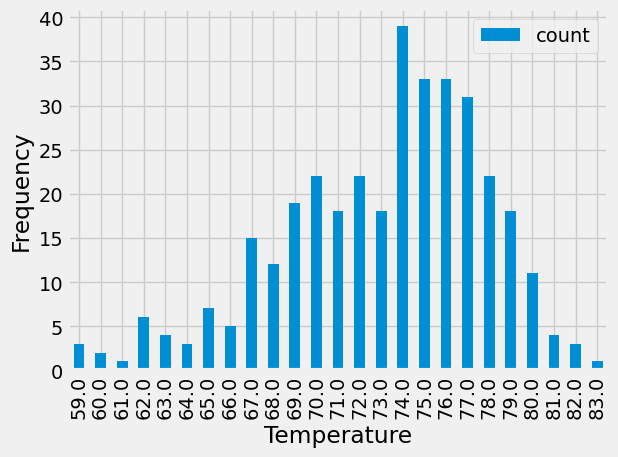

In [124]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [Measurement.tobs,
        func.count(Measurement.tobs)]
station_data = session.query(*sel).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    filter(Measurement.station == top_station).\
    group_by(Measurement.tobs).\
    order_by(Measurement.tobs).all()

station_df = pd.DataFrame(station_data, columns=['tobs', 'count'])
station_df.reset_index(inplace=True)
station_df.plot.bar(x='tobs', y='count')
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

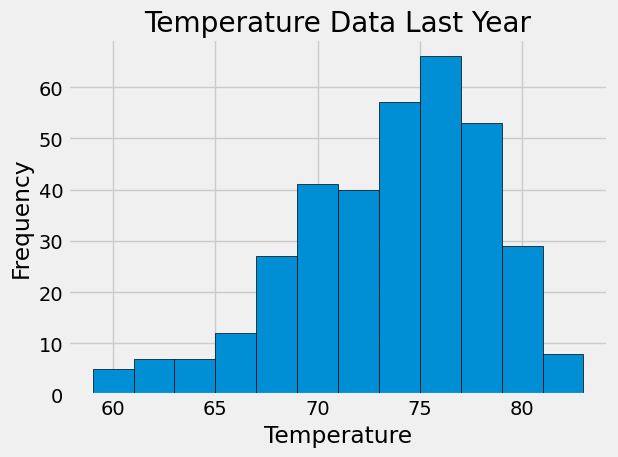

In [125]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station 
station_data = session.query(Measurement.tobs).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    filter(Measurement.station == top_station).all()


temperatures = [result[0] for result in station_data]

# Plot the results as a histogram
plt.hist(temperatures, bins=12, edgecolor='black')
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Temperature Data Last Year")
plt.tight_layout()
plt.show()

# Close Session

In [126]:
# Close Session
session.close()